## Predictive modeling - Linear Regression model (Daily mean tempreture)

### **Before removing outliers**

In [301]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf

In [302]:
kandy_weather = pd.read_csv('../data/processed/kandy_weather_cleaned.csv', index_col=0, parse_dates=['time'])

In [303]:
#drop highly correlated columns 
kandy_weather = kandy_weather.drop(columns=['max_temperature', 'min_temperature', 'apparent_temperature_mean'])

In [304]:
kandy_weather.head()

,weathercode,mean_temperature,shortwave_radiation,rainfall,max_wind_speed,max_wind_gust,dominant_Wind_Direction,evapotranspiration,rain_tomorrow,year,month,day
time,,,,,,,,,,,,
2010-01-01,2,22.0,18.09,0.0,15.3,38.9,57,3.43,0,2010,1,1
2010-01-02,2,22.2,15.47,0.0,13.3,33.1,46,2.95,1,2010,1,2
2010-01-03,51,22.1,14.99,0.1,10.7,28.1,40,2.84,1,2010,1,3
2010-01-04,51,21.9,16.55,0.6,10.4,29.2,23,3.16,0,2010,1,4
2010-01-05,1,20.8,22.68,0.0,9.7,27.0,28,4.18,0,2010,1,5


In [305]:
print(kandy_weather.columns.tolist())

['weathercode', 'mean_temperature', 'shortwave_radiation', 'rainfall', 'max_wind_speed', 'max_wind_gust', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'year', 'month', 'day']


### **1.First Approach: Manual One-Hot Encoding**

In [306]:

# --- Define features and target ---
numerical_vars = ['shortwave_radiation', 'rainfall', 'max_wind_speed', 
                  'max_wind_gust', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'year']  
categorical_vars = ['weathercode'] 
target = 'mean_temperature'

# --- One-hot encode categorical variables using get_dummies ---
columns_to_use = categorical_vars + numerical_vars + [target]
kandy_weather_dummies = pd.get_dummies(kandy_weather[columns_to_use],
                                       columns=categorical_vars,
                                       drop_first=True)

# --- Separate features and target ---
x = kandy_weather_dummies.drop(columns=target)
y = kandy_weather_dummies[target]

# --- Split data based on year (chronological split) ---
train_set = kandy_weather_dummies[kandy_weather_dummies['year'] <= 2018]
validation_set = kandy_weather_dummies[kandy_weather_dummies['year'] == 2019]
test_set = kandy_weather_dummies[kandy_weather_dummies['year'] >= 2020]

# Compute indices for slicing the dummy-encoded X and y
train_end = len(train_set)
val_end = train_end + len(validation_set)

x_train, y_train = x.iloc[:train_end], y.iloc[:train_end]
x_val, y_val = x.iloc[train_end:val_end], y.iloc[train_end:val_end]
x_test, y_test = x.iloc[val_end:], y.iloc[val_end:]

In [307]:
kandy_weather_dummies

,shortwave_radiation,rainfall,max_wind_speed,max_wind_gust,dominant_Wind_Direction,evapotranspiration,rain_tomorrow,year,mean_temperature,weathercode_1,weathercode_2,weathercode_3,weathercode_51,weathercode_53,weathercode_55,weathercode_61,weathercode_63,weathercode_65
time,,,,,,,,,,,,,,,,,,
2010-01-01,18.09,0.0,15.3,38.9,57,3.43,0,2010,22.0,False,True,False,False,False,False,False,False,False
2010-01-02,15.47,0.0,13.3,33.1,46,2.95,1,2010,22.2,False,True,False,False,False,False,False,False,False
2010-01-03,14.99,0.1,10.7,28.1,40,2.84,1,2010,22.1,False,False,False,True,False,False,False,False,False
2010-01-04,16.55,0.6,10.4,29.2,23,3.16,0,2010,21.9,False,False,False,True,False,False,False,False,False
2010-01-05,22.68,0.0,9.7,27.0,28,4.18,0,2010,20.8,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,18.17,3.1,16.6,45.7,221,3.51,1,2023,24.0,False,False,False,False,True,False,False,False,False
2023-06-14,18.26,4.0,16.8,42.5,218,3.56,1,2023,24.4,False,False,False,False,True,False,False,False,False
2023-06-15,17.12,0.6,14.2,37.1,217,3.53,1,2023,24.7,False,False,False,True,False,False,False,False,False


In [308]:
# Fit the model
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [309]:
# --- Get feature names from the X_train DataFrame ---
feature_names = x_train.columns

# --- Extract coefficients and intercept from the model ---
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# --- Create a DataFrame for coefficients ---
coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# --- Add intercept as a separate row (optional) ---
intercept_row = pd.DataFrame({
    'Feature': ['Intercept'],
    'Coefficient': [intercept]
})

# --- Combine intercept and coefficients ---
coef_table = pd.concat([intercept_row, coef_table], ignore_index=True)

# --- Display the table ---
print(coef_table)

                    Feature  Coefficient
0                 Intercept   -25.785346
1       shortwave_radiation    -0.594365
2                  rainfall    -0.003480
3            max_wind_speed    -0.060028
4             max_wind_gust     0.024571
5   dominant_Wind_Direction     0.001903
6        evapotranspiration     3.814209
7             rain_tomorrow     0.348685
8                      year     0.022003
9             weathercode_1     0.360247
10            weathercode_2     0.876008
11            weathercode_3     0.975431
12           weathercode_51     1.450181
13           weathercode_53     1.649102
14           weathercode_55     1.600483
15           weathercode_61     1.590976
16           weathercode_63     1.528565
17           weathercode_65     1.510894


In [310]:
def evaluate_model(model, X, y, dataset_name):
    """Evaluate model performance"""
    predictions = model.predict(X)
    
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  RMSE: {rmse:.4f}°C")
    print(f"  MAE:  {mae:.4f}°C")
    print(f"  R²:   {r2:.4f}")
    
    return predictions, {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate on all sets
train_pred, train_metrics = evaluate_model(lr_model, x_train, y_train, "Training")
val_pred, val_metrics = evaluate_model(lr_model, x_val, y_val, "Validation")
test_pred, test_metrics = evaluate_model(lr_model, x_test, y_test, "Test")


Training Set Performance:
  RMSE: 0.5699°C
  MAE:  0.4261°C
  R²:   0.7589

Validation Set Performance:
  RMSE: 0.5473°C
  MAE:  0.4041°C
  R²:   0.8066

Test Set Performance:
  RMSE: 0.6013°C
  MAE:  0.4585°C
  R²:   0.7138


### **Second Approach: Pipeline + ColumnTransformer**

In [311]:
numerical_vars = ['shortwave_radiation', 'rainfall', 'max_wind_speed', 
                  'max_wind_gust', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'month']
categorical_vars = ['weathercode']
target = 'mean_temperature'

# Features and target (raw, do not dummy encode yet)
x = kandy_weather[categorical_vars + numerical_vars]
y = kandy_weather[target]

# Train/test split (chronological)
train_set = kandy_weather[kandy_weather['year'] <= 2018]
validation_set = kandy_weather[kandy_weather['year'] == 2019]
test_set = kandy_weather[kandy_weather['year'] >= 2020]

train_end = len(train_set)
val_end = train_end + len(validation_set)

x_train, y_train = x.iloc[:train_end], y.iloc[:train_end]
x_val, y_val = x.iloc[train_end:val_end], y.iloc[train_end:val_end]
x_test, y_test = x.iloc[val_end:], y.iloc[val_end:]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_vars),          # one-hot encode categorical
    ('num', StandardScaler(), numerical_vars)                        # scale numerical
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('lr_model', LinearRegression())
])

pipeline.fit(x_train, y_train)


,steps,"[('preprocessing', ...), ('lr_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [312]:
# Get OneHotEncoder step inside ColumnTransformer
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get feature names generated by OneHotEncoder
encoded_feature_names = ohe.get_feature_names_out(categorical_vars).tolist()

# Final full list of features (encoded categorical + numerical)
full_feature_names = encoded_feature_names + numerical_vars

In [313]:
# Get feature names after preprocessing
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# Get coefficients and intercept
coefs = pipeline.named_steps['lr_model'].coef_
intercept = pipeline.named_steps['lr_model'].intercept_

# Combine into DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

print(f'intercept : {intercept}')

print(coef_df)


intercept : 22.106708538640532
                         Feature  Coefficient
0             cat__weathercode_1     0.366960
1             cat__weathercode_2     0.889443
2             cat__weathercode_3     1.006383
3            cat__weathercode_51     1.469432
4            cat__weathercode_53     1.665464
5            cat__weathercode_55     1.615392
6            cat__weathercode_61     1.606664
7            cat__weathercode_63     1.556515
8            cat__weathercode_65     1.553980
9       num__shortwave_radiation    -2.493876
10                 num__rainfall    -0.049221
11           num__max_wind_speed    -0.261727
12            num__max_wind_gust     0.253713
13  num__dominant_Wind_Direction     0.182061
14       num__evapotranspiration     3.307711
15            num__rain_tomorrow     0.143270
16                    num__month    -0.055142


In [314]:
def evaluate_model(model, X, y, dataset_name):
    """Evaluate model performance"""
    predictions = pipeline.predict(X)
    
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  RMSE: {rmse:.4f}°C")
    print(f"  MAE:  {mae:.4f}°C")
    print(f"  R²:   {r2:.4f}")
    
    return predictions, {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate on all sets
train_pred, train_metrics = evaluate_model(pipeline, x_train, y_train, "Training")
val_pred, val_metrics = evaluate_model(pipeline, x_val, y_val, "Validation")
test_pred, test_metrics = evaluate_model(pipeline, x_test, y_test, "Test")


Training Set Performance:
  RMSE: 0.5705°C
  MAE:  0.4256°C
  R²:   0.7583

Validation Set Performance:
  RMSE: 0.5726°C
  MAE:  0.4215°C
  R²:   0.7883

Test Set Performance:
  RMSE: 0.5678°C
  MAE:  0.4234°C
  R²:   0.7448


In [315]:
y_pred = pipeline.predict(x_test)

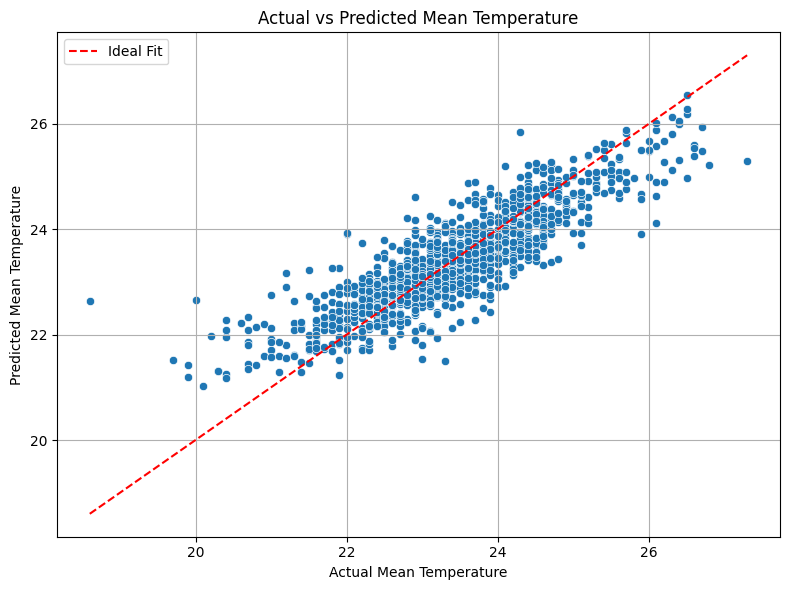

In [316]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Mean Temperature')
plt.ylabel('Predicted Mean Temperature')
plt.title('Actual vs Predicted Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [317]:
# --- Combine training data for statsmodels ---
train_data = x_train.copy()
train_data['mean_temperature'] = y_train

scaler = StandardScaler()
train_scaled = train_data.copy()
train_scaled[numerical_vars] = scaler.fit_transform(train_scaled[numerical_vars])

# --- Build the regression formula ---
formula = "mean_temperature ~ C(weathercode) + shortwave_radiation + rainfall + max_wind_speed + max_wind_gust + dominant_Wind_Direction + evapotranspiration + rain_tomorrow + month"

# --- Fit the OLS regression model ---
model = smf.ols(formula=formula, data=train_scaled).fit()

# --- Print full model summary ---
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       mean_temperature   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     603.4
Date:                Thu, 18 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:57:44   Log-Likelihood:                -2819.3
No. Observations:                3287   AIC:                             5675.
Df Residuals:                    3269   BIC:                             5784.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Residuals Analysis

In [318]:
y_pred = pipeline.predict(x_test)
residuals = y_test - y_pred

### Normality of errors

In [319]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Durbin–Watson Statistic: {dw_stat:.4f}")

Durbin–Watson Statistic: 0.6977


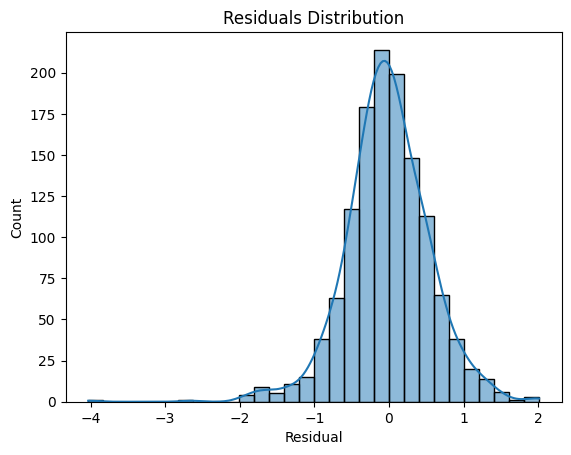

In [320]:
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.show()


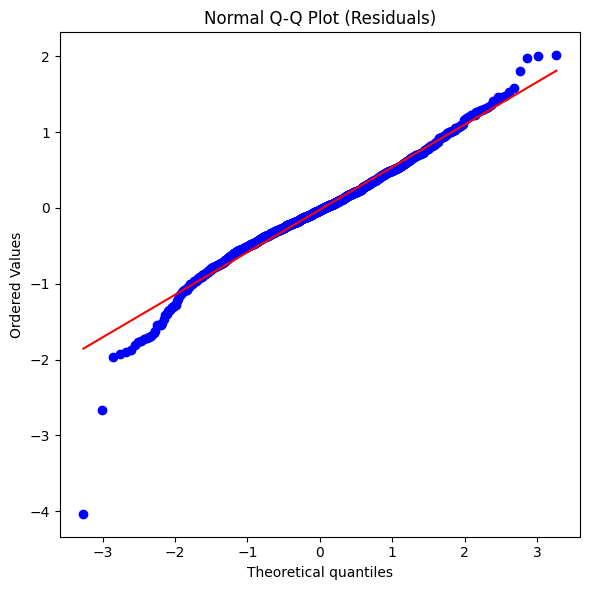

In [321]:
from scipy.stats import probplot

plt.figure(figsize=(6, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot (Residuals)')
plt.tight_layout()
plt.show()

In [322]:
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print("Shapiro-Wilk Test: stat=%.3f, p=%.3f" % (stat, p))

Shapiro-Wilk Test: stat=0.975, p=0.000


### Homoscedasticity

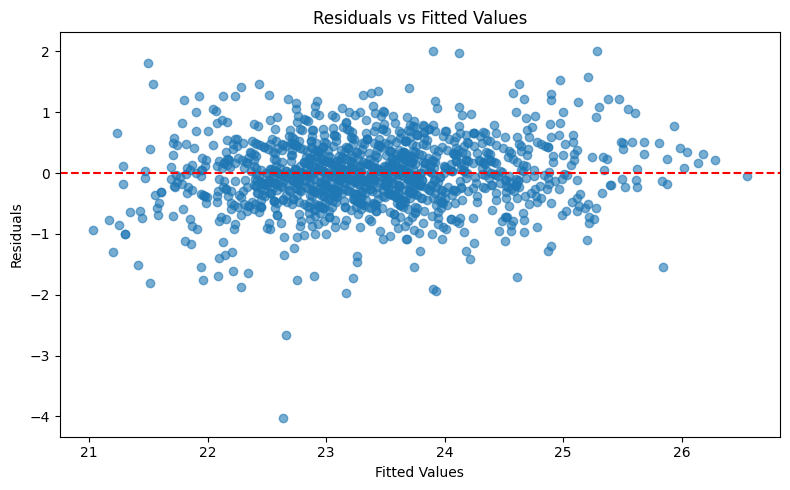

In [323]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

Observations from your plot:

1.Centered around zero

    The residuals are scattered around the red line (y=0).

    This means your model is unbiased on average (no strong systematic under/over prediction). ✅

2.Spread of residuals

    The variance of residuals looks fairly constant across fitted values (between ~21 and 26).

    There is no strong funnel shape (e.g., narrow on one side, wide on the other).

    This suggests homoscedasticity (constant variance) is likely satisfied. ✅

3.No clear pattern

    Residuals don’t form curves or trends.

    If you saw a U-shape or wave-like structure, it would mean your linear model is missing some nonlinearity.

    Here, the scatter looks random → linearity assumption holds. ✅

4.Outliers

    A few points fall far below (e.g., residuals < -3).

    These are potential outliers that may influence the model. ⚠️

In [324]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Requires residuals & design matrix
import statsmodels.api as sm
exog = sm.add_constant(x_test)  # add intercept
bp_test = het_breuschpagan(residuals, exog)

print("\n--- Breusch-Pagan Test ---")
print(f"Test Statistic: {bp_test[0]:.4f}")
print(f"p-value       : {bp_test[1]:.4f}")



--- Breusch-Pagan Test ---
Test Statistic: 96.6918
p-value       : 0.0000


### **Multicollinearity: VIF**

In [325]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# --- One-hot encode categorical variables ---
X = pd.get_dummies(
    train_data[['weathercode', 'shortwave_radiation', 'rainfall',
                'max_wind_speed', 'max_wind_gust',
                'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'month']],
    drop_first=True
)

# --- Ensure numeric dtype (convert bool -> int, etc.) ---
X = X.astype(float)

# --- Drop rows with NaNs if any ---
X = X.dropna()

# --- Calculate VIF ---
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                   Feature         VIF
0              weathercode    8.485118
1      shortwave_radiation  637.424798
2                 rainfall    1.608124
3           max_wind_speed   74.638705
4            max_wind_gust  108.242652
5  dominant_Wind_Direction    5.899135
6       evapotranspiration  588.444881
7            rain_tomorrow    7.297790
8                    month    4.818690
